In [1]:
from metabox import rcwa, utils, modeling, assembly
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

d:\Documents\MetaMaterial_MetaOptics\metacode\menv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(rcwa.get_avaliable_materials())

['GaN', 'MoO3', 'N-BK7', 'Nb2O5', 'quartz', 'Si3N4', 'Si_ir', 'Si_visible', 'TiO2', 'ZnO', 'ZrO2']


In [3]:
# Now let's define some materials for our simulations
TiO2 = rcwa.Material('Si3N4')
quartz = rcwa.Material('quartz')

# Define sampling wavelengths, here we only simulate 3 wavelength for simplicity
# In practice, you may want to simulate more wavelengths for better sampling density.
incidence = utils.Incidence(wavelength=np.linspace(1500e-9, 1600e-9, 4))

# Define the unit cell periodicity
periodicity = (350e-9, 350e-9)

# Define RCWA simulation configuration
sim_config = rcwa.SimConfig(
    xy_harmonics=(7, 7), # Fourier orders in x and y
    resolution=256, # grid resolution per periodicity
    return_tensor=True, # return tensor instead of a SimulationResult object
    minibatch_size=10 # number of simulations to run in parallel
)

# Instantiate a `Feature` to parameterize the width of the square
width = utils.Feature(vmin=100e-9, vmax=500e-9, name="radius", sampling=100)
circle = rcwa.Circle(material=TiO2, radius=width, x_pos= 0, y_pos=0)
patterned_layer = rcwa.Layer(material=1, thickness=500e-9, shapes=[circle])
substrate = rcwa.Layer(material=quartz, thickness=1000e-9)
cell = rcwa.UnitCell(
    layers=[patterned_layer, substrate], 
    periodicity=periodicity,
)
protocell = rcwa.ProtoUnitCell(cell)

sim_lib = modeling.sample_protocell(
    protocell=protocell,
    incidence=incidence,
    sim_config=sim_config,
)    
save_path = r"D:\Documents\MetaMaterial_MetaOptics\metacode\notebooks\example_folder"
sim_lib.save('TiO2_circle_sim_lib',save_path, overwrite=True)

100%|██████████| 10/10 [01:08<00:00,  6.84s/it]

Saved the atom library to D:\Documents\MetaMaterial_MetaOptics\metacode\notebooks\example_folder\TiO2_circle_sim_lib.pkl


In [4]:
# Now that we have saved our simulations, we can load them back in
# and use them to train a metamodel neural network.
loaded_sim_lib = modeling.load_simulation_library('TiO2_circle_sim_lib', save_path)

# Let's train a DNN with the following architecture:
# Input layer -> 10 (relu) -> 128 (tanh) -> 256 (relu) -> 256 (tanh) -> 128 (relu) -> 10 (tanh) -> Output layer
model = modeling.create_and_train_model(
    loaded_sim_lib,
    n_epochs=100,
    hidden_layer_units_list=[10, 128, 512, 512, 512, 128, 10],
    activation_list=['relu', 'tanh', 'relu', 'relu', 'relu', 'tanh', 'tanh'],
    train_batch_size=100,
)
model.save('TiO2_circle_metamodel', save_path, overwrite=True)

100%|██████████| 100/100 [00:07<00:00, 13.70epoch/s, loss=1.25e-5, val_loss=0.000213]


Saved metamodel to D:\Documents\MetaMaterial_MetaOptics\metacode\notebooks\example_folder\TiO2_circle_metamodel


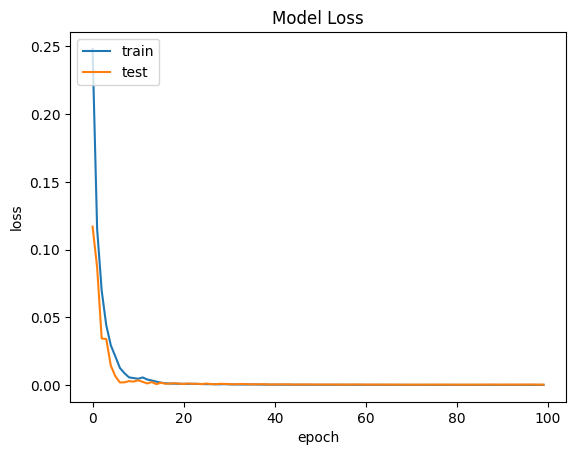

In [5]:
model.plot_training_history()

10/10 [==============================] - 0s 2ms/step


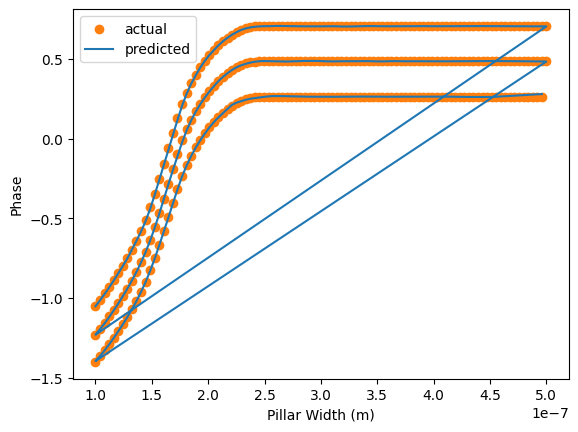

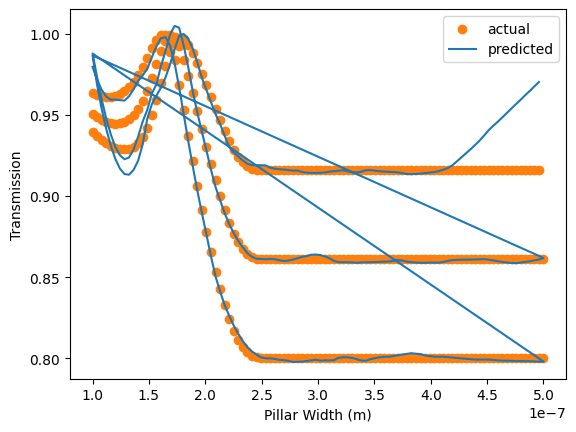

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Let's load the metamodel and compare the predictions to the atom library.
mm = modeling.load_metamodel("TiO2_circle_metamodel", save_path)

# Load the simulated atom library to compare.
sim_lib = modeling.load_simulation_library("TiO2_circle_sim_lib", save_path)
inputs = sim_lib.get_training_x()
outputs = sim_lib.get_training_y()

inputs = inputs[-300:-1]
outputs = outputs[-300:-1][:, 0]
prediction = mm.model.predict(inputs)[:, 0]

# Plot phase and transmission predictions
plt.xlabel("Pillar Width (m)")
plt.ylabel("Phase")
plt.scatter(inputs[:, 1], np.angle(outputs), label="actual", c="C1")
plt.plot(inputs[:, 1], np.angle(prediction), label="predicted")
plt.legend()
plt.show()


plt.xlabel("Pillar Width (m)")
plt.ylabel("Transmission")
plt.scatter(inputs[:, 1], np.abs(outputs)**2, label="actual", c="C1")
plt.plot(inputs[:, 1], np.abs(prediction)**2, label="predicted")
plt.legend()
plt.show()

### Single Metasurface imaging system 

In [ ]:
# Load the metamodel we created
metamodel = modeling.load_metamodel("TiO2_circle_metamodel", save_path)
# Define the bounds of the feature.
metamodel.set_feature_constraint("width", vmin=100e-9, vmax=500e-9)

# Create a metasurface.
metasurface = assembly.Metasurface(
    diameter=100e-6,              # 100 microns in diameter
    refractive_index=1.0,         # the propagation medium after the metasurface
    thickness=300e-6,             # the distance to the next surface
    metamodel=metamodel,          # the metamodel to use
    enable_propagator_cache=True, # cache the propagators for faster computation
    set_structures_variable=True, # set the structures as a variable to optimize
)

# Define the incidence wavelengths and angles.
incidence = assembly.Incidence(
    wavelength=np.linspace(1500e-9, 1600e-9, 3),
    phi=[0],             # normal incidence
    theta=[0],           # normal incidence
)

# Create a lens assembly.
lens_assembly = assembly.LensAssembly(
        surfaces=[metasurface], # Define the array of surfaces. Here only one.
        incidence=incidence,   # Define the incidence.
        figure_of_merit=assembly.FigureOfMerit.LOG_STREHL_RATIO, # Define the figure of merit.
)

# Use the Adam optimizer to optimize the lens assembly. This rate should be
# empirically determined.
optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-8
)
optimizer.build(lens_assembly.get_variables())

# Optimize the lens assembly. Returns the best-optimized lens assembly and the loss history.
history = assembly.optimize_single_lens_assembly(
    lens_assembly, 
    optimizer, 
    n_iter=50,
    verbose=1,
    keep_best=True,
)

Loss: 2.315150: 100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


In [8]:
# At this point, you can save the optimized metasurface to a file.
lens_assembly.save("lens_assembly", overwrite=True, save_dir= save_path)

# to export to GDSII, you can use the following
from metabox import export
export.generate_gds(metasurface, 0, "lens_assembly", "./example_folder")

d:\Documents\MetaMaterial_MetaOptics\metacode\menv\lib\site-packages\metabox\propagation.py:326: RuntimeWarning: invalid value encountered in divide
  weighted_intensity_distributions /= np.max(


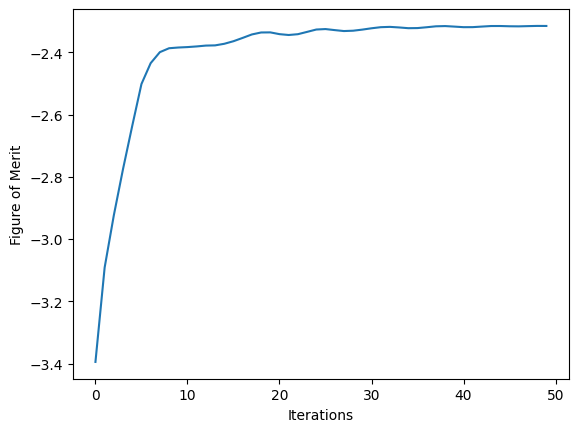

d:\Documents\MetaMaterial_MetaOptics\metacode\menv\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


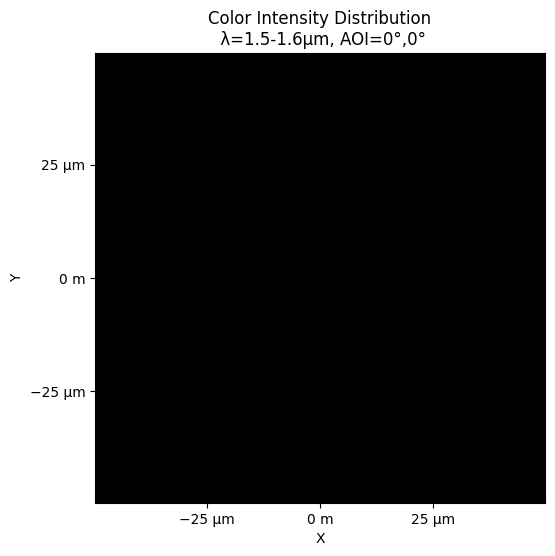

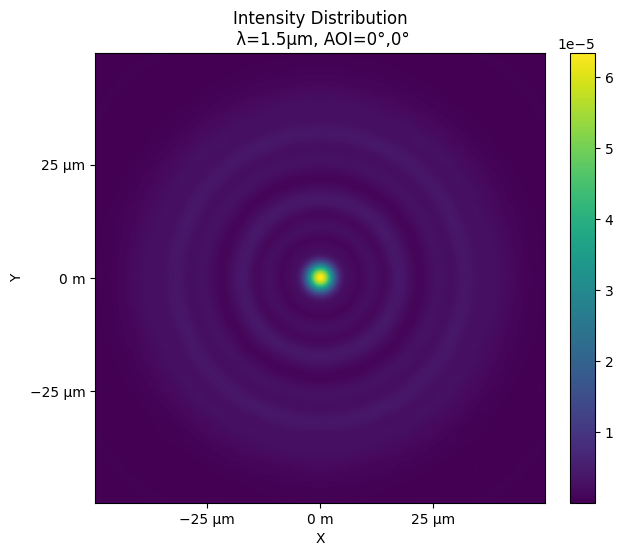

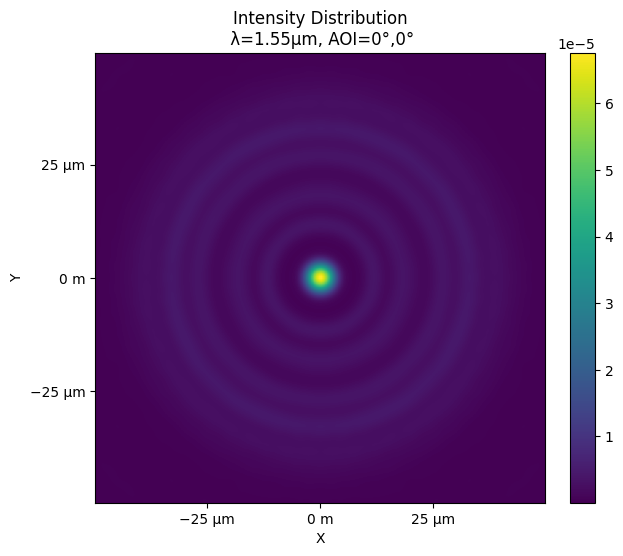

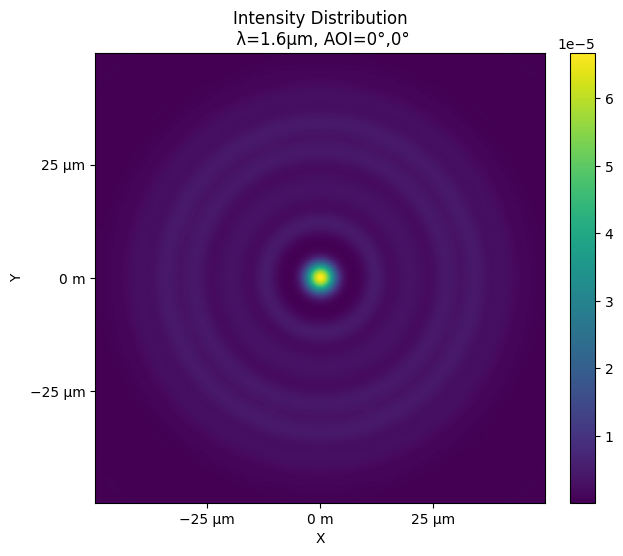

In [9]:
# Plot the history of the figure of merit.
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Figure of Merit")

# Compare the optimized and unoptimized fields.
lens_assembly.show_color_psf()
lens_assembly.show_psf()

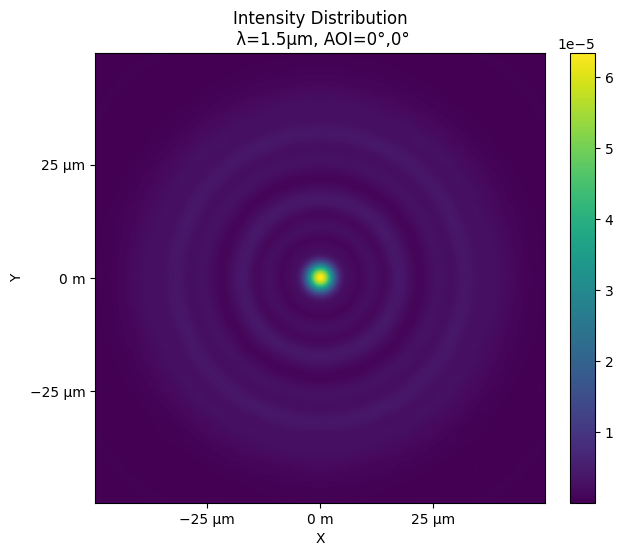

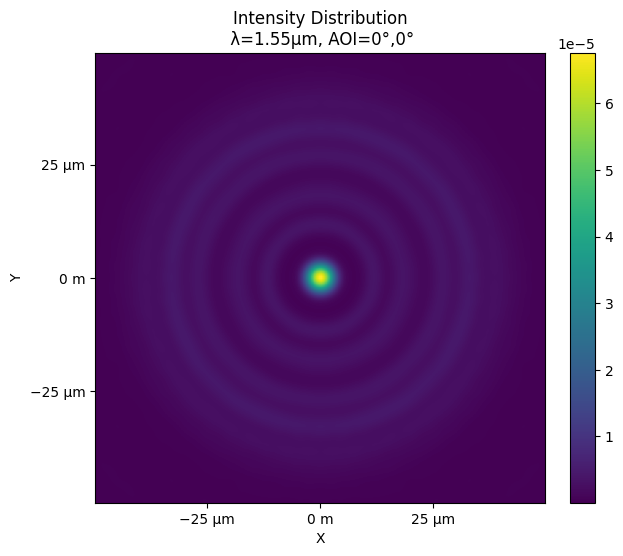

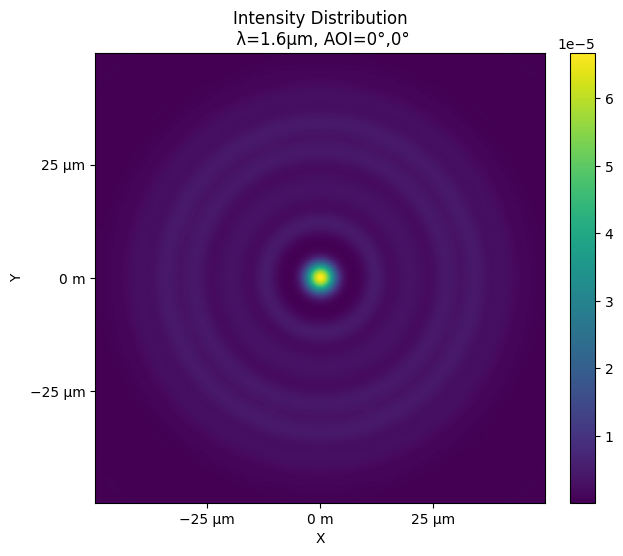

In [10]:
# For a new session, you can load the optimized metasurface from a file again.
from metabox import assembly

loaded_assembly = assembly.load_lens_assembly("lens_assembly", save_path)

# The PSFs should be the same.
loaded_assembly.show_psf()

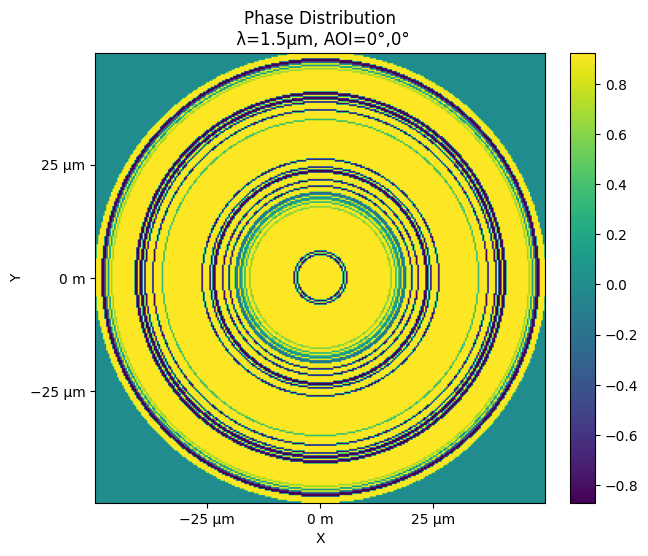

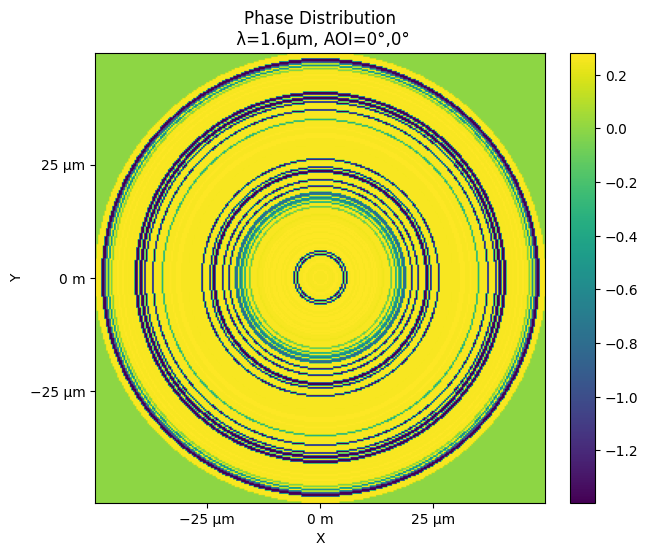

In [11]:
### Phase profile

# we can access any surface in the assembly by calling the surfaces attribute.
# In this case, we only have one surface, so we can access it like so:
metasurface = loaded_assembly.surfaces[0]

# Now we can access field modulation given some incidence wavelengths and angles.
incidence = assembly.Incidence(
    wavelength=[1500e-9, 1600e-9],
    phi=[0],             # normal incidence
    theta=[0],           # normal incidence
)
modulation = metasurface.get_modulation_2d(incidence)

# Now let's plot the phase modulation of the metasurface.
modulation.show_phase()

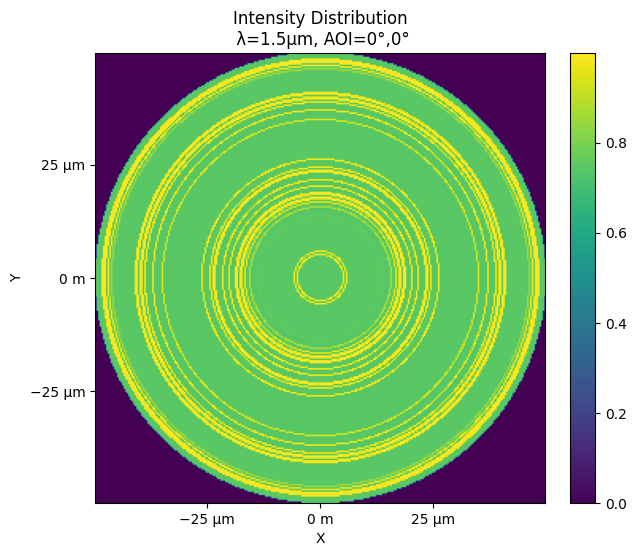

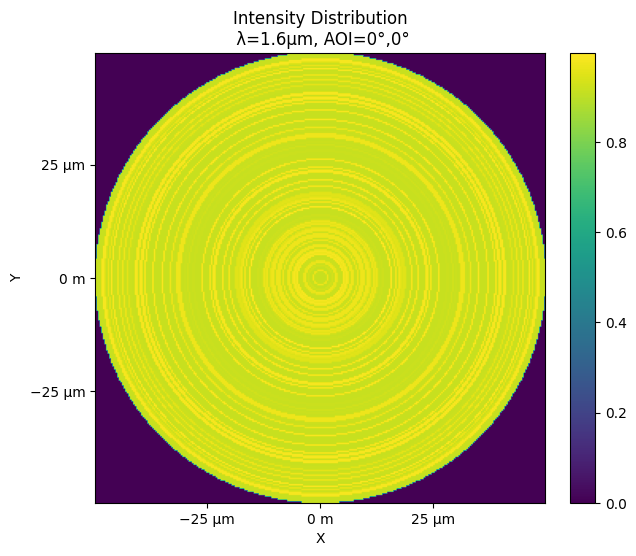

In [12]:
# We could also plot the intensity modulation of the metasurface.
modulation.show_intensity()